In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

In [2]:
@jit
def func(x):
    return np.tan(0.49*np.pi*np.cos(1/(1.1 + np.sin(x**2))))

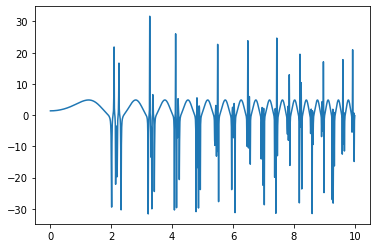

In [3]:
xs = np.linspace(0,10,1000)
plt.plot(xs, func(xs))

In [4]:
from queue import Queue
import multiprocessing as mp
from collections import namedtuple

@jit
def step_is_big(f, x, h, params):
        return abs(f(x) - f(x+h))*h > params.step_prec

@jit
def worker_thread(f, start, stop, params):
        x = start
        h = params.initial_step
        accumulator = 0
        while x < stop:
            if x + h > stop:
                h = stop - x
            
            if step_is_big(f, x, h, params):
                h = min(h/2, params.minimal_step)
            else:
                accumulator += h*f(x)
                x += h
        
        return accumulator

IntegratorParams = namedtuple('IntegratorParams', ['initial_step', 'minimal_step', 'step_prec'])
class Integrator:
    def __init__(self, workers=None, initial_step=10**(-4), minimal_step=10**(-6), step_prec=10**(-6)):
        self.task_q = Queue()
        self.pool = mp.Pool(processes=workers)

        self.params = IntegratorParams(initial_step, minimal_step, step_prec)
        
    def integrate(self, f, a, b):
        if b < a:
            a,b = b,a

        N = 100
        async_res = []
        for i in range(1, N+1):
            d = (b-a)/N
            async_res.append(self.pool.apply_async(worker_thread, (f, (i-1)*d, i*d, self.params)))
        
        result = 0
        for obj in async_res:
            obj.wait()
            result += obj.get()
        return result
        

integ = Integrator()
integ.integrate(func, 0, 10)

10.064432507935912